# Summary

* I fit a single sequential convolutional network to the images reproduced from the 20-dimensional representation for three different representations found earlier.
* The best classifier that I find scores 97% f1-score for the 'is-a-bag' class on validation data.




In [2]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Fashion_MNIST'

In [5]:
import os
from joblib import dump, load
from random import randint
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from keras.utils import to_categorical
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.base import BaseEstimator, TransformerMixin
class GreyScale(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
      
    def fit(self, X, y=None):
        _, *self.img_dims = X.shape
        return self
        
    def transform(self, X):
        return X.reshape(-1, *self.img_dims, 1)
    
    def inverse_transform(self, X):
        return X.reshape(-1, *self.img_dims)


Using TensorFlow backend.


---
Process the data so that they adhere to the task at hand: perform binary classifying of the upscaled 20-dimensional images: as either a handbag or not-a-handbag. This means that all 'non-bags'are labelled as zero, wheras 'bags' are labelled as one. The two classes have non-equal frequencies of course (9 : 1), which translates into the class-weight parameter-vector.

In [0]:
(X_trainval, y_trainval), (_, _) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

X20a_train = load(os.path.join(path,'X20a_train.joblib'))
X20a_val = load(os.path.join(path,'X20a_val.joblib'))
X20b_train = load(os.path.join(path,'X20b_train.joblib'))
X20b_val = load(os.path.join(path,'X20b_val.joblib'))
X20c_train_A = load(os.path.join(path,'X20c_train_A.joblib'))
X20c_train_B = load(os.path.join(path,'X20c_train_B.joblib'))
X20c_train_C = load(os.path.join(path,'X20c_train_C.joblib'))
X20c_train_D = load(os.path.join(path,'X20c_train_D.joblib'))
X20c_train_E = load(os.path.join(path,'X20c_train_E.joblib'))
X20c_train_F = load(os.path.join(path,'X20c_train_F.joblib'))
X20c_train = np.concatenate((X20c_train_A, X20c_train_B, X20c_train_C, X20c_train_D, X20c_train_E, X20c_train_F), axis=0)
X20c_val = load(os.path.join(path,'X20c_val.joblib'))

greyscale = GreyScale()
X_train = greyscale.fit_transform(X_train)
X_val = greyscale.fit_transform(X_val)
X20a_train = greyscale.fit_transform(X20a_train)
X20a_val = greyscale.transform(X20a_val)
X20b_train = greyscale.transform(X20b_train)
X20b_val = greyscale.transform(X20b_val)
X20c_train = greyscale.transform(X20c_train)
X20c_val = greyscale.transform(X20c_val)

y_train[y_train != 8] = 0
y_train[y_train == 8] = 1
y_train_binary = to_categorical(y_train)

y_val[y_val != 8] = 0
y_val[y_val == 8] = 1
y_val_binary = to_categorical(y_val)

class_weights = compute_class_weight('balanced', (0, 1), y_train)

---
Fit to a convolution net with batch-normalization, and softmax at the end.

In [8]:
def my_model():
  model = Sequential()
  activ = 'relu'
  model.add(Conv2D(filters=8, kernel_size=(8, 8), padding='same', activation=activ, input_shape=(28,28,1)))
  model.add(MaxPooling2D((3,3)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=16, kernel_size=(4, 4), padding='same', activation=activ))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation=activ))
  model.add(Flatten())
  model.add(Dense(128, activation=activ))
  model.add(Dropout(0.1))
  model.add(Dense(2, activation='softmax'))
  return model


my_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 8)         520       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 8)           32        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 16)          2064      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 16)          64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          2080      
__________

---
Use our best encoder for start: the autoencoder based on dense layers.

In [0]:
X20_train, X20_val = X20b_train, X20b_val

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 18s 334us/step - loss: 0.0560 - binary_accuracy: 0.9806 - val_loss: 0.0299 - val_binary_accuracy: 0.9907
Epoch 2/10
54000/54000 [==============================] - 17s 307us/step - loss: 0.0238 - binary_accuracy: 0.9925 - val_loss: 0.0259 - val_binary_accuracy: 0.9923
Epoch 3/10
54000/54000 [==============================] - 17s 307us/step - loss: 0.0200 - binary_accuracy: 0.9937 - val_loss: 0.0249 - val_binary_accuracy: 0.9922
Epoch 4/10
54000/54000 [==============================] - 17s 306us/step - loss: 0.0175 - binary_accuracy: 0.9941 - val_loss: 0.0269 - val_binary_accuracy: 0.9918
Epoch 5/10
54000/54000 [==============================] - 16s 305us/step - loss: 0.0157 - binary_accuracy: 0.9945 - val_loss: 0.0219 - val_binary_accuracy: 0.9933
Epoch 6/10
54000/54000 [==============================] - 17s 308us/step - loss: 0.0138 - binary_accuracy: 0.9955 - val_loss: 0.0214 - v

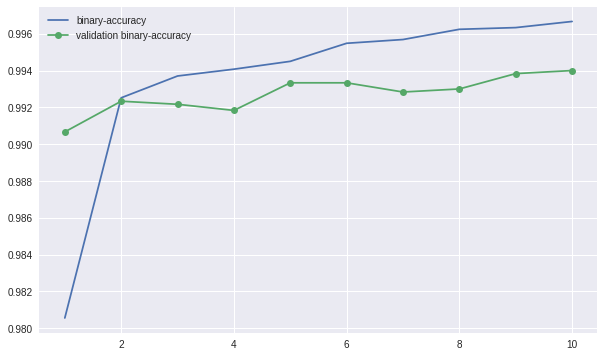

In [58]:
model1 = my_model()
model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['binary_accuracy'])

history = model1.fit(X20_train, y_train_binary, batch_size = 32, epochs=10, validation_data=(X20_val, y_val_binary), class_weight = class_weights)

plt.figure(figsize=(10, 6))
x = range(1, len(history.history['binary_accuracy']) + 1)
plt.plot(x, history.history['binary_accuracy'], '-', label='binary-accuracy')
plt.plot(x, history.history['val_binary_accuracy'], '-o', label='validation binary-accuracy')
plt.legend()
plt.show()

In [0]:
model1.save(os.path.join(path, 'clf20_b.h5'))

In [0]:
model1 = load_model(os.path.join(path,'clf20_b.h5'))

Predict binary labels of the validation set.

In [72]:
y_val_pred = model1.predict(X20_val)
y_val_pred_binary = np.round(y_val_pred)
y_val_pred_binary.shape

(6000, 2)

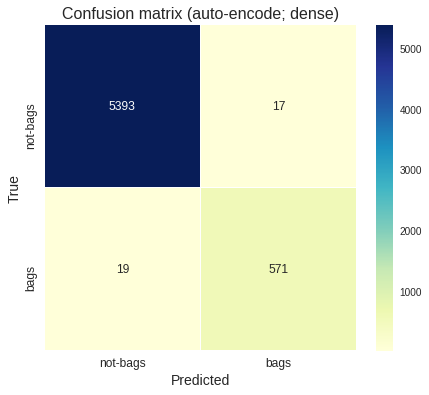

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true=y_val_binary[:,1], y_pred=y_val_pred_binary[:,1])
fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap="YlGnBu",linewidths=.2)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.set_xticklabels(['not-bags', 'bags'], fontsize=12)
ax.set_yticklabels(['bags', 'not-bags'], fontsize=12)
#plt.yticks(rotation=0)
plt.title('Confusion matrix (auto-encode; dense)', fontsize=16)
plt.show()

We manage to have precision and recall (of the 'bags'-category) whose values are close to each other and are equal to about 0.97%.

The micro average of the scores is of course better due to the 10fold imbalance between the 'bags' vs 'not-bags' categories.

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision in the 'handbags'-class: {precision_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"Precision in the 'not-bags'-class: {precision_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. precision of two classes: {precision_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. precision of two classes: {precision_score(y_val_binary, y_val_pred_binary, average='macro')}")
print("---")
print(f"Recall in the 'handbags'-class: {recall_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"Recall in the 'not-bags'-class: {recall_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. recall of two classes: {recall_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. recall of two classes: {recall_score(y_val_binary, y_val_pred_binary, average='macro')}")
print("---")
print(f"F1 in the 'handbags'-class: {f1_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"F1 in the 'not-bags'-class: {f1_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. f1 of two classes: {f1_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. f1 of two classes: {f1_score(y_val_binary, y_val_pred_binary, average='macro')}")

Precision in the 'handbags'-class: 0.9710884353741497
Precision in the 'not-bags'-class: 0.9964892830746489
Micro-avg. precision of two classes: 0.994
Macro-avg. precision of two classes: 0.9837888592243993
---
Recall in the 'handbags'-class: 0.9677966101694915
Recall in the 'not-bags'-class: 0.9968576709796673
Micro-avg. recall of two classes: 0.994
Macro-avg. recall of two classes: 0.9823271405745794
---
F1 in the 'handbags'-class: 0.9694397283531409
F1 in the 'not-bags'-class: 0.9966734429865088
Micro-avg. f1 of two classes: 0.994
Macro-avg. f1 of two classes: 0.9830565856698248


One could also be interested to see the ROC and Precision vs Recall curves constructed using the softmax-probabilities produced by the network. Here they are.

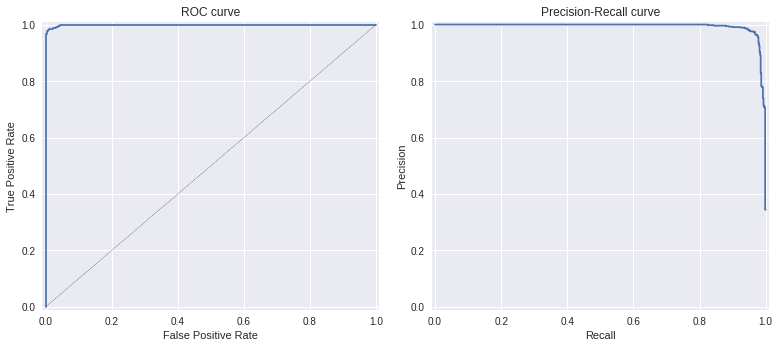

In [75]:
from sklearn.metrics import roc_curve, precision_recall_curve

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

ax = axes[0]

fpr, tpr, thresholds = roc_curve(y_val_binary[:,1], y_val_pred[:,1])
ax.plot(fpr, tpr)

ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

ax = axes[1]

precision, recall, _ = precision_recall_curve(y_val_binary[:,1], y_val_pred[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

Finally, have a direct look at the missclassified images. We devide them explicitly into false-positive and false-negative 'bags'.

False positives: non-bags classified as bags.
Left: the original 28x28 image. Right: the image reproduced from 20-dim.


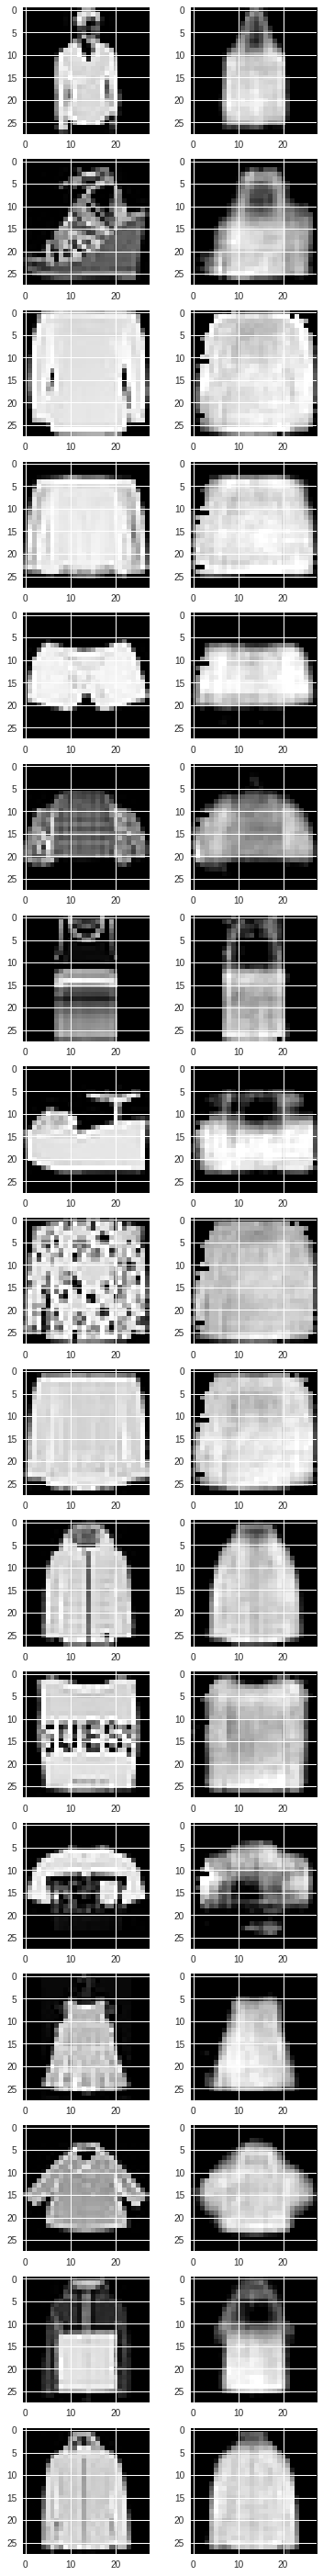

In [76]:
print(f"False positives: non-bags classified as bags.")
print("Left: the original 28x28 image. Right: the image reproduced from 20-dim.")
FP = (y_val_pred_binary[:,1] * y_val_binary[:,0]).astype('bool')
X_val_FP = greyscale.inverse_transform(X_val[FP])
X20_val_FP = greyscale.inverse_transform(X20_val[FP])

size = 3
rows = np.sum(FP)
plt.figure(figsize=(size * 2, size * rows))

for i, img_pair in enumerate(zip(X_val_FP, X20_val_FP)):
  for j, img in enumerate(img_pair):
    plt.subplot(rows, 2, 2 * i + j + 1)
    plt.imshow(img, cmap='gray') 

False negatives: bags classified as not-bags.
Left: the original 28x28 image. Right: the image reproduced from 20-dim.


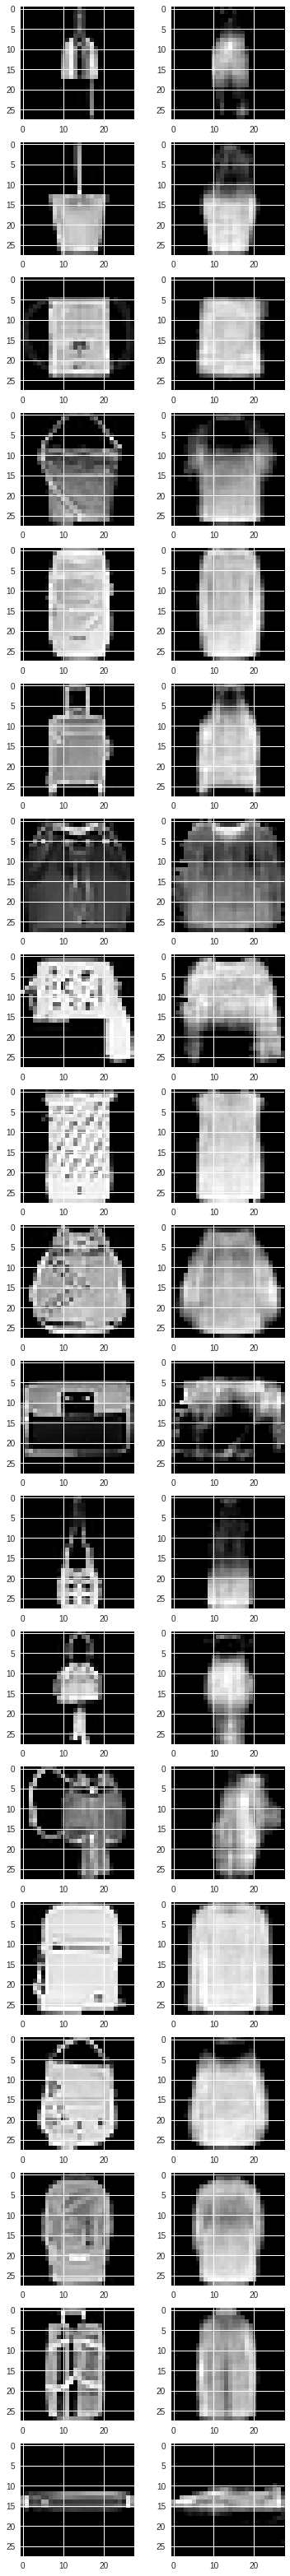

In [77]:
print(f"False negatives: bags classified as not-bags.")
print("Left: the original 28x28 image. Right: the image reproduced from 20-dim.")
FN = (y_val_pred_binary[:,0] * y_val_binary[:,1]).astype('bool')
X_val_FN = greyscale.inverse_transform(X_val[FN])
X20_val_FN = greyscale.inverse_transform(X20_val[FN])

size = 3
rows = np.sum(FN)
plt.figure(figsize=(size * 2, size * rows))

for i, img_pair in enumerate(zip(X_val_FN, X20_val_FN)):
  for j, img in enumerate(img_pair):
    plt.subplot(rows, 2, 2 * i + j + 1)
    plt.imshow(img, cmap='gray') 

---
Repeat the training and validation using the SVD-based encoder.

In [0]:
X20_train, X20_val = X20a_train, X20a_val

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 20s 377us/step - loss: 0.0549 - binary_accuracy: 0.9817 - val_loss: 0.0373 - val_binary_accuracy: 0.9893
Epoch 2/10
54000/54000 [==============================] - 17s 322us/step - loss: 0.0294 - binary_accuracy: 0.9908 - val_loss: 0.0319 - val_binary_accuracy: 0.9910
Epoch 3/10
54000/54000 [==============================] - 17s 322us/step - loss: 0.0252 - binary_accuracy: 0.9917 - val_loss: 0.0303 - val_binary_accuracy: 0.9913
Epoch 4/10
54000/54000 [==============================] - 17s 322us/step - loss: 0.0229 - binary_accuracy: 0.9925 - val_loss: 0.0298 - val_binary_accuracy: 0.9915
Epoch 5/10
54000/54000 [==============================] - 17s 321us/step - loss: 0.0205 - binary_accuracy: 0.9930 - val_loss: 0.0275 - val_binary_accuracy: 0.9922
Epoch 6/10
54000/54000 [==============================] - 17s 321us/step - loss: 0.0189 - binary_accuracy: 0.9937 - val_loss: 0.0276 - v

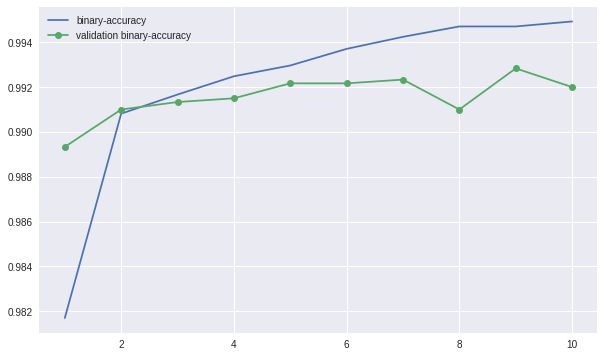

In [85]:
model2 = my_model()
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['binary_accuracy']) 

history = model2.fit(X20_train, y_train_binary, batch_size = 32, epochs=10, validation_data=(X20_val, y_val_binary), class_weight = class_weights)

plt.figure(figsize=(10, 6))
x = range(1, len(history.history['binary_accuracy']) + 1)
plt.plot(x, history.history['binary_accuracy'], '-', label='binary-accuracy')
plt.plot(x, history.history['val_binary_accuracy'], '-o', label='validation binary-accuracy')
plt.legend()
plt.show()

In [0]:
model2.save(os.path.join(path, 'clf20_a.h5'))

In [0]:
model2 = load_model(os.path.join(path,'clf20_a.h5'))

In [87]:
y_val_pred = model2.predict(X20_val)
y_val_pred_binary = np.round(y_val_pred)
y_val_pred_binary.shape

(6000, 2)

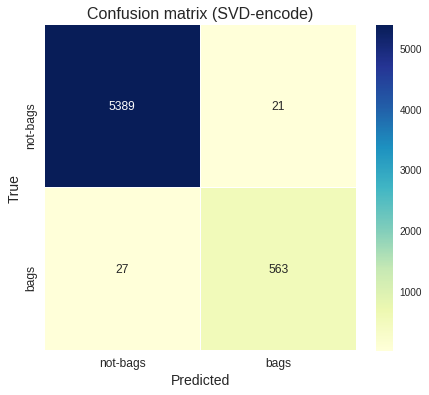

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true=y_val_binary[:,1], y_pred=y_val_pred_binary[:,1])
fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap="YlGnBu",linewidths=.2)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.set_xticklabels(['not-bags', 'bags'], fontsize=12)
ax.set_yticklabels(['bags', 'not-bags'], fontsize=12)
#plt.yticks(rotation=0)
plt.title('Confusion matrix (SVD-encode)', fontsize=16)
plt.show()

In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision in the 'handbags'-class: {precision_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"Precision in the 'not-bags'-class: {precision_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. precision of two classes: {precision_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. precision of two classes: {precision_score(y_val_binary, y_val_pred_binary, average='macro')}")
print("---")
print(f"Recall in the 'handbags'-class: {recall_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"Recall in the 'not-bags'-class: {recall_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. recall of two classes: {recall_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. recall of two classes: {recall_score(y_val_binary, y_val_pred_binary, average='macro')}")
print("---")
print(f"F1 in the 'handbags'-class: {f1_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"F1 in the 'not-bags'-class: {f1_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. f1 of two classes: {f1_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. f1 of two classes: {f1_score(y_val_binary, y_val_pred_binary, average='macro')}")

Precision in the 'handbags'-class: 0.964041095890411
Precision in the 'not-bags'-class: 0.9950147710487445
Micro-avg. precision of two classes: 0.992
Macro-avg. precision of two classes: 0.9795279334695777
---
Recall in the 'handbags'-class: 0.9542372881355933
Recall in the 'not-bags'-class: 0.9961182994454714
Micro-avg. recall of two classes: 0.992
Macro-avg. recall of two classes: 0.9751777937905324
---
F1 in the 'handbags'-class: 0.959114139693356
F1 in the 'not-bags'-class: 0.9955662294476261
Micro-avg. f1 of two classes: 0.992
Macro-avg. f1 of two classes: 0.977340184570491


---
Finally repeat for the auto-encoder based on the convolutinonal net.

In [0]:
X20_train, X20_val = X20c_train, X20c_val

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 22s 413us/step - loss: 0.0567 - binary_accuracy: 0.9813 - val_loss: 0.0376 - val_binary_accuracy: 0.9887
Epoch 2/10
54000/54000 [==============================] - 18s 329us/step - loss: 0.0299 - binary_accuracy: 0.9911 - val_loss: 0.0335 - val_binary_accuracy: 0.9897
Epoch 3/10
54000/54000 [==============================] - 18s 331us/step - loss: 0.0260 - binary_accuracy: 0.9920 - val_loss: 0.0305 - val_binary_accuracy: 0.9913
Epoch 4/10
54000/54000 [==============================] - 18s 332us/step - loss: 0.0236 - binary_accuracy: 0.9926 - val_loss: 0.0322 - val_binary_accuracy: 0.9890
Epoch 5/10
54000/54000 [==============================] - 18s 332us/step - loss: 0.0217 - binary_accuracy: 0.9930 - val_loss: 0.0293 - val_binary_accuracy: 0.9912
Epoch 6/10
54000/54000 [==============================] - 18s 331us/step - loss: 0.0199 - binary_accuracy: 0.9938 - val_loss: 0.0311 - v

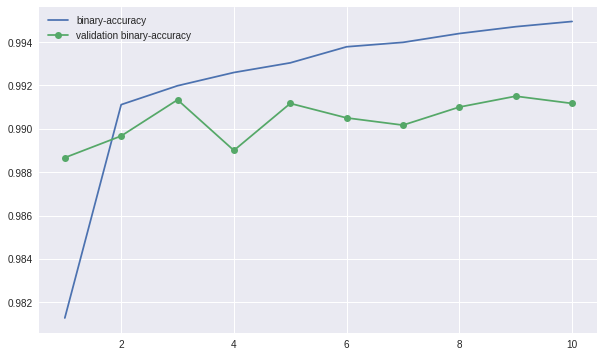

In [105]:
model3 = my_model()
model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['binary_accuracy'])

history = model3.fit(X20_train, y_train_binary, batch_size = 32, epochs=10, validation_data=(X20_val, y_val_binary), class_weight = class_weights)

plt.figure(figsize=(10, 6))
x = range(1, len(history.history['binary_accuracy']) + 1)
plt.plot(x, history.history['binary_accuracy'], '-', label='binary-accuracy')
plt.plot(x, history.history['val_binary_accuracy'], '-o', label='validation binary-accuracy')
plt.legend()
plt.show()

In [0]:
model3.save(os.path.join(path, 'clf20_c.h5'))

In [0]:
model3 = load_model(os.path.join(path,'clf20_c.h5'))

In [108]:
y_val_pred = model3.predict(X20_val)
y_val_pred_binary = np.round(y_val_pred)
y_val_pred_binary.shape

(6000, 2)

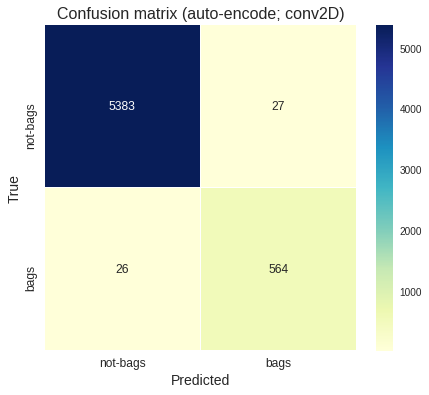

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true=y_val_binary[:,1], y_pred=y_val_pred_binary[:,1])
fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap="YlGnBu",linewidths=.2)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.set_xticklabels(['not-bags', 'bags'], fontsize=12)
ax.set_yticklabels(['bags', 'not-bags'], fontsize=12)
#plt.yticks(rotation=0)
plt.title('Confusion matrix (auto-encode; conv2D)', fontsize=16)
plt.show()

In [110]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision in the 'handbags'-class: {precision_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"Precision in the 'not-bags'-class: {precision_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. precision of two classes: {precision_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. precision of two classes: {precision_score(y_val_binary, y_val_pred_binary, average='macro')}")
print("---")
print(f"Recall in the 'handbags'-class: {recall_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"Recall in the 'not-bags'-class: {recall_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. recall of two classes: {recall_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. recall of two classes: {recall_score(y_val_binary, y_val_pred_binary, average='macro')}")
print("---")
print(f"F1 in the 'handbags'-class: {f1_score(y_val_binary[:,1], y_val_pred_binary[:,1])}")
print(f"F1 in the 'not-bags'-class: {f1_score(y_val_binary[:,0], y_val_pred_binary[:,0])}")
print(f"Micro-avg. f1 of two classes: {f1_score(y_val_binary, y_val_pred_binary, average='micro')}")
print(f"Macro-avg. f1 of two classes: {f1_score(y_val_binary, y_val_pred_binary, average='macro')}")

Precision in the 'handbags'-class: 0.9543147208121827
Precision in the 'not-bags'-class: 0.9951931965243114
Micro-avg. precision of two classes: 0.9911666666666666
Macro-avg. precision of two classes: 0.974753958668247
---
Recall in the 'handbags'-class: 0.9559322033898305
Recall in the 'not-bags'-class: 0.9950092421441774
Micro-avg. recall of two classes: 0.9911666666666666
Macro-avg. recall of two classes: 0.975470722767004
---
F1 in the 'handbags'-class: 0.9551227773073666
F1 in the 'not-bags'-class: 0.9951012108327942
Micro-avg. f1 of two classes: 0.9911666666666666
Macro-avg. f1 of two classes: 0.9751119940700804


Only the first auto-encoder did slightly better than PCA when using the one convolutional network constructed at the beginning as our classifier.

We will test the setup auto-encode(dense) + model1 in a separate notebook.

---
## End